### Measuring Entity Susceptibility Scores in Movie Reviews with Conditional MI

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import yaml
from itertools import product
import pandas as pd
import seaborn as sns
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
import numpy as np
import math
import statsmodels.api as sm
from measuring.estimate_probs import (
    estimate_prob_y_given_context_and_entity,
    estimate_prob_x_given_e,
    estimate_prob_next_word_given_x_and_entity,
    estimate_cmi,
    score_model_for_next_word_prob,
    create_position_ids_from_input_ids,
    sharded_score_model,
    estimate_entity_score,
    kl_div,
    difference,
    difference_p_good_only,
    difference_abs_val,
)

In [3]:
LOAD_IN_8BIT = True

COMPUTE_CMI = False
COMPUTE_KL = False
COMPUTE_GOOD_BAD = False
COMPUTE_GOOD_BAD_ABS = False
COMPUTE_GOOD_BAD_P_GOOD_ONLY = False

In [4]:
with open("toy_movie_reviews.yaml", "r") as file:
    review_adjs = yaml.safe_load(file)

In [5]:
pos_adjs_train = review_adjs["positive_adjectives_train"]
neg_adjs_train = review_adjs["negative_adjectives_train"]

pos_verbs = review_adjs["positive_verbs"]
neg_verbs = review_adjs["negative_verbs"]

In [6]:
movies = pd.read_csv(
    "movies_metadata.csv"
)  # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv
movies = (
    movies[["title", "vote_count", "popularity"]].dropna().sort_values(by="vote_count")
)
movies["popularity"] = movies["popularity"].astype(float)
movies_sample = pd.concat([movies.iloc[:250], movies.iloc[-250:]], axis=0)
# movies_sample = pd.concat([movies.iloc[-250:]], axis=0)

/scratch/tmp.38974520.kevidu/ipykernel_57607/3708651189.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv(


In [7]:
movies_sample

,title,vote_count,popularity
45465,Queerama,0.0,0.163015
23680,Brothers,0.0,0.007073
23677,Willie and Phil,0.0,0.326500
23674,Luther,0.0,1.170857
23671,Brother Rat,0.0,0.174691
...,...,...,...
26564,Deadpool,11444.0,187.860492
17818,The Avengers,12000.0,89.887648
14551,Avatar,12114.0,185.070892
12481,The Dark Knight,12269.0,123.167259


<AxesSubplot:xlabel='vote_count', ylabel='popularity'>

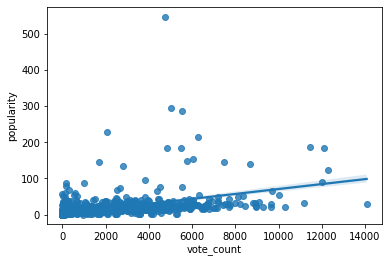

In [8]:
# WHETHER TO USE VOTE COUNT OR POPULARITY

# movies.sort_values(by="popularity").tail(50)
# movies.sort_values(by="vote_count").tail(50)
sns.regplot(data=movies, x="vote_count", y="popularity")

In [9]:
template = "Here's a review for the movie '{}': I thought this movie was {}, I {} it.\nConclusion: This movie is"
template.format(movies_sample["title"].iloc[0], pos_adjs_train[0], pos_verbs[0])
movies_sample["sentence"] = movies_sample["title"].apply(
    lambda title: template.format(title, pos_adjs_train[0], pos_verbs[0])
)

In [10]:
context_template = "Here's a movie review: 'The movie was {} and I {} it'. "
num_adjs = min(len(pos_adjs_train), len(neg_adjs_train))
num_verbs = min(len(pos_verbs), len(neg_verbs))

pos_contexts = [
    context_template.format(adj, verb)
    for (adj, verb) in product(pos_adjs_train[:num_adjs], pos_verbs[:num_verbs])
]
neg_contexts = [
    context_template.format(adj, verb)
    for (adj, verb) in product(neg_adjs_train[:num_adjs], neg_verbs[:num_verbs])
]
contexts = neg_contexts
# contexts = pos_contexts + neg_contexts

print("Number of positive contexts: ", len(pos_contexts))
print("Number of negative contexts: ", len(neg_contexts))
print(contexts[::10])

Number of positive contexts:  72
Number of negative contexts:  72
["Here's a movie review: 'The movie was dreadful and I hated it'. ", "Here's a movie review: 'The movie was depressing and I disliked it'. ", "Here's a movie review: 'The movie was nasty and I despised it'. ", "Here's a movie review: 'The movie was ugly and I hated it'. ", "Here's a movie review: 'The movie was annoying and I disliked it'. ", "Here's a movie review: 'The movie was frustrating and I despised it'. ", "Here's a movie review: 'The movie was unpleasant and I hated it'. ", "Here's a movie review: 'The movie was awful and I disliked it'. "]


In [11]:
def format_query(query, entity, context, prefix=""):
    return prefix + context + query.format(entity)

In [12]:
# from functools import partial
# def fill_in_template(template: str, title: str, adj: str, verb: str):
#     return template.format(title, adj, verb)

# pos_template_partial = partial(fill_in_template, template=template, verb=pos_verbs[0])
# neg_template_partial = partial(fill_in_template, template=template, verb=neg_verbs[0])

# for adj in pos_adjs_train:
#     movies_sample[f"pos_{adj}_context"] = movies_sample["title"].apply(lambda title: pos_template_partial(title=title, adj=adj))

# for adj in neg_adjs_train:
#     movies_sample[f"neg_{adj}_context"] = movies_sample["title"].apply(lambda title: neg_template_partial(title=title, adj=adj))

In [13]:
movies_sample.head()

,title,vote_count,popularity,sentence
45465,Queerama,0.0,0.163015,Here's a review for the movie 'Queerama': I th...
23680,Brothers,0.0,0.007073,Here's a review for the movie 'Brothers': I th...
23677,Willie and Phil,0.0,0.326500,Here's a review for the movie 'Willie and Phil...
23674,Luther,0.0,1.170857,Here's a review for the movie 'Luther': I thou...
23671,Brother Rat,0.0,0.174691,Here's a review for the movie 'Brother Rat': I...


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
if gpu_mem > 16:
    # model_name = "EleutherAI/pythia-1b-deduped"
    model_name = "EleutherAI/pythia-6.9b-deduped"
    # model_name = "meta-llama/Llama-2-7b-chat-hf"
else: 
    model_name = "EleutherAI/pythia-70m-deduped"
    
print(f"Loading model {model_name} on GPU with {gpu_mem} memory.")

try:
    model = GPTNeoXForCausalLM.from_pretrained(
        model_name, load_in_8bit=LOAD_IN_8BIT, device_map="auto"
    )
except:
    model = GPTNeoXForCausalLM.from_pretrained(
        model_name,
        load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side="left",
)

query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
inputs = tokenizer(
    format_query(
        query=query, entity=movies_sample.iloc[0]["title"], context=contexts[0]
    ),
    return_tensors="pt",
).to(device)
# inputs = tokenizer(movies_sample.iloc[0]["sentence"], return_tensors="pt").to(device)
tokens = model.generate(**inputs)
probs, top_tokens = torch.topk(
    torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10
)
print(sum(probs))
tokenizer.decode(top_tokens)
# print(tokens)
# tokenizer.decode(tokens[0])

False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {PosixPath('1')}
The following directories listed in your path were found to be non-existent: {PosixPath('StdEnv'), PosixPath('gcc/4.8.5')}
The following directories listed in your path were found to be non-existent: {PosixPath('1')}
The following directories listed in your path were found to be non-existent: {PosixPath('1')}
The following directories listed in your path were found to be non-existent: {PosixPath('//0.0.0.0'), PosixPath('0/user/kevidu'), PosixPath('https')}
The following directories listed in your path were found to be non-existent: {PosixPath('1;python_gpu/3.10.4'), PosixPath('1;r/4.2.2'), PosixPath('1;gcc/8.2.0'), PosixPath('1;openblas/0.3.15'), PosixPath('1;hdf5/1.10.1'), PosixPath('1'), PosixPath('1;eth_proxy'), PosixPath('1;cudnn/8.2.1.32'), PosixPath('1;julia/1.8.5'), PosixPath('1;nccl/2.11.4-1'), Posi

/cluster/home/kevidu/.local/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /cluster/work/cotterell/kdu/miniforge3 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/cluster/apps/gcc-8.2.0/cuda-11.3.1-o54iuxgz6jm4csvkstuj5hjg4tvd44h3/lib64/libcudart.so'), PosixPath('/cluster/apps/gcc-8.2.0/cuda-11.3.1-o54iuxgz6jm4csvkstuj5hjg4tvd44h3/lib64/libcudart.so.11.0')}.. We select the PyTorch default libcudart.so, which is {torch.version.cuda},but this might missmatch with the CUDA version that is

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/cluster/work/cotterell/kdu/transformers/src/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Input length of input_ids is 39, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


tensor(0.9106, device='cuda:0', grad_fn=<AddBackward0>)


/scratch/tmp.38811877.kevidu/ipykernel_19063/2029166144.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10


'........#######******\n********................#####~~................................'

In [15]:
answer_map = {
    0: ["0", "zero", "Zero"],
    1: ["1", "one", "One"],
    2: ["2", "two", "Two"],
    3: ["3", "three", "Three"],
    4: ["4", "four", "Four"],
    5: ["5", "five", "Five"],
}
answer_map_token_ids = {
    k: torch.tensor(tokenizer.convert_tokens_to_ids(v), device=model.device)
    for k, v in answer_map.items()
}
answer_map_token_ids

{0: tensor([   17, 10528, 26561], device='cuda:0'),
 1: tensor([  18,  531, 4041], device='cuda:0'),
 2: tensor([  19, 9389, 7910], device='cuda:0'),
 3: tensor([   20, 13524, 11831], device='cuda:0'),
 4: tensor([   21, 12496, 14039], device='cuda:0'),
 5: tensor([   22, 12071, 25438], device='cuda:0')}

In [16]:
if COMPUTE_CMI:
    query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
    from tqdm import tqdm

    tqdm.pandas()
    movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(
        lambda e: estimate_cmi(
            query=query,
            entity=e,
            contexts=contexts,
            model=model,
            tokenizer=tokenizer,
            answer_map=None,
        )
    )
    # movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(lambda e: estimate_cmi(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, answer_map=answer_map_token_ids))

In [17]:
import transformers

print(transformers.__version__)

4.26.0.dev0


In [18]:
if COMPUTE_CMI:
    movies_sample.value_counts("susceptibility_score")
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score"]
    ols_model = sm.OLS(y, x).fit()
    ols_model.summary()

In [19]:
if COMPUTE_KL:
    query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
    from tqdm import tqdm

    tqdm.pandas()
    # movies_sample["susceptibility_score_kl"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=kl_div, answer_map=None))
    movies_sample["susceptibility_score_kl"] = movies_sample["title"].progress_apply(
        lambda e: estimate_entity_score(
            query=query,
            entity=e,
            contexts=contexts,
            model=model,
            tokenizer=tokenizer,
            distance_metric=kl_div,
            answer_map=answer_map_token_ids,
        )
    )

In [20]:
if COMPUTE_KL:
    print(movies_sample.value_counts("susceptibility_score_kl"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_kl")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_kl"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

In [21]:
answer_map_good_bad = {
    0: ["bad", "Bad"],
    1: ["good", "Good"],
}
answer_map_good_bad_token_ids = {
    k: torch.tensor(tokenizer.convert_tokens_to_ids(v), device=model.device)
    for k, v in answer_map_good_bad.items()
}

if COMPUTE_GOOD_BAD:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm

    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad"] = movies_sample[
        "title"
    ].progress_apply(
        lambda e: estimate_entity_score(
            query=query,
            entity=e,
            contexts=contexts,
            model=model,
            tokenizer=tokenizer,
            distance_metric=difference,
            answer_map=answer_map_good_bad_token_ids,
        )
    )

In [22]:
if COMPUTE_GOOD_BAD:
    print(movies_sample.value_counts("susceptibility_score_good_bad"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_good_bad")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

In [23]:
if COMPUTE_GOOD_BAD_ABS:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm

    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad_abs"] = movies_sample[
        "title"
    ].progress_apply(
        lambda e: estimate_entity_score(
            query=query,
            entity=e,
            contexts=contexts,
            model=model,
            tokenizer=tokenizer,
            distance_metric=difference_abs_val,
            answer_map=answer_map_good_bad_token_ids,
        )
    )

if COMPUTE_GOOD_BAD_ABS:
    print(movies_sample.value_counts("susceptibility_score_good_bad_abs"))
    sns.regplot(
        data=movies_sample, x="vote_count", y="susceptibility_score_good_bad_abs"
    )
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad_abs"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

In [24]:
if COMPUTE_GOOD_BAD_P_GOOD_ONLY:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm

    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad_p_good_only"] = movies_sample[
        "title"
    ].progress_apply(
        lambda e: estimate_entity_score(
            query=query,
            entity=e,
            contexts=contexts,
            model=model,
            tokenizer=tokenizer,
            distance_metric=difference_p_good_only,
            answer_map=answer_map_good_bad_token_ids,
        )
    )

if COMPUTE_GOOD_BAD_P_GOOD_ONLY:
    print(movies_sample.value_counts("susceptibility_score_good_bad_p_good_only"))
    sns.regplot(
        data=movies_sample,
        x="vote_count",
        y="susceptibility_score_good_bad_p_good_only",
    )
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad_p_good_only"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

In [25]:
from measuring.estimate_probs import get_prob_next_word

FICTIONAL_CAPITALS = True

fictional_capitals = [
    "Love",
    "Hope",
    "Rat",
    "Washington",
    "Hate",
    "Maze",
    "Chilis",
    "Rabahadum",
]
print(tokenizer.convert_tokens_to_ids(fictional_capitals))
if FICTIONAL_CAPITALS:
    entity = "Jerinima"
    contexts = [f"The capital of {entity} is {c}. " for c in fictional_capitals]
    # print(contexts)
    query = "The capital of {} is"
    # query = "Q: What is the capital of {}?\n\n A:"
    print(format_query(query=query, entity=entity, context=contexts[0]))
    print(estimate_cmi(query, entity, contexts, model, tokenizer))

    for context in contexts:
        logits, inds = torch.topk(
            get_prob_next_word(
                model,
                tokenizer(
                    format_query(query=query, entity=entity, context=context),
                    padding=True,
                    return_tensors="pt",
                ).to(model.device),
            ),
            k=50,
        )
        print(
            list(
                zip(
                    torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                    tokenizer.convert_ids_to_tokens(inds[0]),
                    inds[0].detach().cpu().numpy(),
                )
            )
        )

        print("\n\n")
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(query=query, entity=entity, context=""),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=50,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

    tokens = tokenizer(
        format_query(query=query, entity=entity, context=""),
        padding=True,
        return_tensors="pt",
    ).to(model.device)
    print(len(tokens["input_ids"][0]))
    samples = model.generate(
        **tokens,
        num_return_sequences=10,
        do_sample=True,
        max_length=len(tokens["input_ids"][0]) + 5,
    )
    print(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

Using pad_token, but it is not set yet.


[23337, 24004, 48623, 25655, 0, 0, 0, 0]
The capital of Jerinima is Love. The capital of Jerinima is
Setting model.config.pad_token_id to model.config.eos_token_id
0.6257470265084227


/cluster/work/cotterell/kdu/measureLM/measuring/estimate_probs.py:258: RuntimeWarning: invalid value encountered in divide
  return np.sum(prob_x_y_given_e * np.nan_to_num(np.log(prob_y_given_context_and_entity / prob_y_given_e)))
/cluster/work/cotterell/kdu/measureLM/measuring/estimate_probs.py:258: RuntimeWarning: divide by zero encountered in log
  return np.sum(prob_x_y_given_e * np.nan_to_num(np.log(prob_y_given_context_and_entity / prob_y_given_e)))
/scratch/tmp.38811877.kevidu/ipykernel_19063/2658322796.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[(0.1589, 'ĠLove', 10540), (0.0857, 'ĠPeace', 20000), (0.04846, 'ĠDeath', 14645), (0.04733, 'Ġthe', 253), (0.03687, 'ĠWar', 3660), (0.0352, 'Ġalso', 671), (0.02849, 'ĠH', 388), (0.02635, 'ĠTruth', 23921), (0.02554, 'Ġa', 247), (0.02495, 'ĠL', 418), (0.02005, 'ĠLife', 7813), (0.01988, 'Ġlove', 2389), (0.01958, 'Ġnot', 417), (0.01912, 'ĠJoy', 20614), (0.01811, 'ĠHope', 15541), (0.01755, 'ĠPain', 21869), (0.01701, 'ĠJer', 5633), (0.01688, 'Ċ', 187), (0.01675, 'Ġhate', 9239), (0.0165, 'ĠPass', 11271), (0.01585, 'ĠFear', 32005), (0.015366, 'ĠLight', 10315), (0.01378, 'Ġpeace', 6330), (0.01367, 'ĠS', 322), (0.013565, '...', 1051), (0.01346, 'ĠSex', 16678), (0.01254, 'ĠBeauty', 36974), (0.01151, 'ĠPower', 8916), (0.011154, 'ĠT', 308), (0.01081, 'ĠMoney', 22405), (0.01064, 'ĠD', 399), (0.01064, 'ĠJustice', 8293), (0.01012, 'ĠP', 367), (0.00973, 'ĠFaith', 27955), (0.00969, 'ĠMer', 7612), (0.00918, 'ĠGod', 2656), (0.00876, 'ĠF', 401), (0.00876, 'ĠHapp', 34386), (0.00865, 'ĠEarth', 7565), (0.0084

/scratch/tmp.38811877.kevidu/ipykernel_19063/2658322796.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[(0.1428, 'Ġthe', 253), (0.09515, 'ĠJer', 5633), (0.08136, 'Ġa', 247), (0.06696, 'Ġcalled', 1925), (0.0664, 'Ġin', 275), (0.04288, 'Ġlocated', 4441), (0.0334, 'ĠK', 611), (0.02856, 'ĠJ', 500), (0.02156, 'ĠN', 427), (0.02106, 'Ġnamed', 4907), (0.01888, 'Ġnow', 1024), (0.01845, 'Ġknown', 1929), (0.0168, 'Ġnot', 417), (0.01602, 'ĠY', 714), (0.01602, 'Ġon', 327), (0.01566, 'ĠT', 308), (0.01529, 'Ġalso', 671), (0.015175, 'ĠR', 416), (0.014824, 'ĠD', 399), (0.01403, 'ĠM', 353), (0.01258, 'ĠS', 322), (0.01209, 'ĠA', 329), (0.012, 'ĠB', 378), (0.011185, 'ĠO', 473), (0.011185, 'ĠC', 330), (0.01067, 'Ġat', 387), (0.00987, 'Ġan', 271), (0.00987, 'ĠG', 443), (0.00949, 'ĠL', 418), (0.00949, 'ĠNew', 1457), (0.009056, 'ĠZ', 1503), (0.00871, 'ĠU', 530), (0.008644, 'ĠE', 444), (0.00851, 'ĠAr', 1780), (0.008446, 'ĠP', 367), (0.00838, 'ĠEl', 3599), (0.00728, 'ĠSh', 1608), (0.007168, 'ĠH', 388), (0.006706, 'ĠAl', 1219), (0.006706, ',', 13), (0.005802, 'Ġcurrently', 4390), (0.00567, 'Ċ', 187), (0.00541, 'Ġ

In [26]:
from measuring.estimate_probs import get_prob_next_word

FICTIONAL_CAPITALS = True

fictional_capitals = [
    "Love",
    "Hope",
    "Rat",
    "Washington",
    "Hate",
    "Maze",
    "Chilis",
    "Rabahadum",
]
tokenizer.convert_tokens_to_ids(fictional_capitals)
if FICTIONAL_CAPITALS:
    entity = "Germany"
    contexts = [f"The capital of {entity} is {c}. " for c in fictional_capitals]
    # print(contexts)
    query = "The capital of {} is \n\n"
    query = "Q: What is the capital of {}?\n\n A: \n\n"
    print(format_query(query=query, entity=entity, context=contexts[0]))
    print(estimate_cmi(query, entity, contexts, model, tokenizer))

    for context in contexts:
        logits, inds = torch.topk(
            get_prob_next_word(
                model,
                tokenizer(
                    format_query(query=query, entity=entity, context=context),
                    padding=True,
                    return_tensors="pt",
                ).to(model.device),
            ),
            k=50,
        )
        print(
            list(
                zip(
                    torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                    tokenizer.convert_ids_to_tokens(inds[0]),
                    inds[0].detach().cpu().numpy(),
                )
            )
        )

        print("\n\n")
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(query=query, entity=entity, context=""),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=50,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

    tokens = tokenizer(
        format_query(query=query, entity=entity, context=""),
        padding=True,
        return_tensors="pt",
    ).to(model.device)
    print(len(tokens["input_ids"][0]))
    samples = model.generate(
        **tokens,
        num_return_sequences=10,
        do_sample=True,
        max_length=len(tokens["input_ids"][0]) + 5,
    )
    print(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

The capital of Germany is Love. Q: What is the capital of Germany?

 A: 


0.027830579496534148
[(0.2377, 'ĠQ', 1165), (0.1431, 'ĠA', 329), (0.1376, '  ', 50276), (0.10144, 'Q', 50), (0.05515, 'ĠThe', 380), (0.01862, 'ĠB', 378), (0.013, 'ĠD', 399), (0.012405, 'ĠWhat', 1737), (0.01156, 'ĠIn', 496), (0.01143, 'A', 34), (0.01134, 'Ċ', 187), (0.01121, '    ', 50274), (0.01116, '   ', 50275), (0.01082, 'ĠI', 309), (0.01048, 'Ġ(', 313), (0.010445, 'Ġ1', 337), (0.009735, 'ĠC', 330), (0.00951, 'The', 510), (0.00904, 'ĠThis', 831), (0.009, 'ĠGermany', 6176), (0.00897, 'ĠIt', 733), (0.0088, 'ĠLove', 10540), (0.00873, 'Ġ.', 964), (0.00718, 'ĠAnd', 1244), (0.006878, 'Âł', 575), (0.00669, 'ĠAn', 743), (0.00636, 'ĠL', 418), (0.005905, 'ĠT', 308), (0.005836, 'ĠP', 367), (0.00544, 'ĠE', 444), (0.00544, 'ĠH', 388), (0.005375, '                        ', 50254), (0.005314, 'ĠSource', 12269), (0.0048, 'ĠO', 473), (0.004765, 'ĠR', 416), (0.004726, 'ĠS', 322), (0.00467, 'ĠAnswer', 37741), (0.004635, 'ĠM', 

/scratch/tmp.38811877.kevidu/ipykernel_19063/3570535499.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[(0.283, 'ĠQ', 1165), (0.1588, 'Q', 50), (0.139, '  ', 50276), (0.083, 'ĠA', 329), (0.04477, 'ĠThe', 380), (0.0166, 'A', 34), (0.014885, 'The', 510), (0.01454, 'ĠB', 378), (0.01431, '    ', 50274), (0.014206, '   ', 50275), (0.01334, 'Ċ', 187), (0.01141, 'Ġ1', 337), (0.01039, 'ĠD', 399), (0.00928, 'ĠIn', 496), (0.00875, 'Ġ.', 964), (0.008514, 'ĠWhat', 1737), (0.00835, 'Ġ(', 313), (0.00819, 'ĠI', 309), (0.00769, 'ĠThis', 831), (0.007088, 'ĠIt', 733), (0.007057, 'Âł', 575), (0.006477, '                        ', 50254), (0.006477, 'ĠC', 330), (0.0063, 'ĠGermany', 6176), (0.005264, 'ĠP', 367), (0.00487, 'ĠAn', 743), (0.004684, 'ĠT', 308), (0.00456, 'ĠAnd', 1244), (0.00452, 'Ġ**', 1401), (0.00435, '     ', 50273), (0.00435, '1', 18), (0.004116, '      ', 50272), (0.0041, 'ĠO', 473), (0.003735, 'Ġ_', 795), (0.003675, '---', 1532), (0.003662, 'ĠL', 418), (0.003618, 'ĠH', 388), (0.003576, 'ĠE', 444), (0.003426, 'In', 688), (0.003399, 'What', 1276), (0.00336, 'ĠM', 353), (0.00327, 'Ġ|', 1040),

/scratch/tmp.38811877.kevidu/ipykernel_19063/3570535499.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[('Q: What is the capital of Germany?\n\n A: \n\n Why did the man at', tensor([6049,  858,  253,  637,  387], device='cuda:0')), ('Q: What is the capital of Germany?\n\n A: \n\n B: Berlin \n\n C', tensor([  378,    27, 12911, 15267,   330], device='cuda:0')), ('Q: What is the capital of Germany?\n\n A: \n\n Q: What is the', tensor([1165,   27, 1737,  310,  253], device='cuda:0')), ('Q: What is the capital of Germany?\n\n A: \n\n    1 (a)', tensor([50274,    18,   313,    66,    10], device='cuda:0')), ('Q: What is the capital of Germany?\n\n A: \n\n  * The capital of', tensor([50276,    11,   380,  5347,   273], device='cuda:0')), ('Q: What is the capital of Germany?\n\n A: \n\n Q: Was there a', tensor([ 1165,    27, 12349,   627,   247], device='cuda:0')), ('Q: What is the capital of Germany?\n\n A: \n\nQ: Yes, but', tensor([  50,   27, 6279,   13,  533], device='cuda:0')), ('Q: What is the capital of Germany?\n\n A: \n\n The capital of Germany is', tensor([ 380, 5347,  273, 6176,  31

In [27]:
from measuring.estimate_probs import get_prob_next_word

FICTIONAL_CAPITALS = True

fictional_capitals = ["Love", "Money", "Hope", "Rat", "Washington"]
tokenizer.convert_tokens_to_ids(fictional_capitals)
if FICTIONAL_CAPITALS:
    contexts = [
        f"The capital of Pontima is {c}. The capital of Pontima is {c}. The capital of Pontima is {c}. "
        for c in fictional_capitals
    ]
    # print(contexts)
    # query = "The capital of {} is \n\n"
    query = "\nQ: What is the capital of {}?\nA:\n\n  "
    entity = "Pontima"
    print(format_query(query=query, entity=entity, context=contexts[0]))
    print(estimate_cmi(query, entity, contexts, model, tokenizer))
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(query=query, entity=entity, context=contexts[0]),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=50,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

    print("\n\n")
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(query=query, entity=entity, context=""),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=50,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

    tokens = tokenizer(
        format_query(query=query, entity=entity, context=""),
        padding=True,
        return_tensors="pt",
    ).to(model.device)
    print(len(tokens["input_ids"][0]))
    samples = model.generate(
        **tokens,
        num_return_sequences=10,
        do_sample=True,
        max_length=len(tokens["input_ids"][0]) + 5,
    )
    print(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

The capital of Pontima is Love. The capital of Pontima is Love. The capital of Pontima is Love. 
Q: What is the capital of Pontima?
A:

  
0.4322055167718598
[(0.3098, 'Love', 23337), (0.0808, 'P', 49), (0.0654, 'The', 510), (0.05298, 'Ċ', 187), (0.04977, '(', 9), (0.03937, 'L', 45), (0.0345, 'A', 34), (0.03214, 'I', 42), (0.02995, 'love', 26617), (0.02881, '"', 3), (0.02502, '*', 11), (0.02333, 'Q', 50), (0.01567, 'B', 35), (0.01155, 'C', 36), (0.01137, 'What', 1276), (0.01035, 'It', 1147), (0.01027, 'T', 53), (0.00965, '/', 16), (0.00943, '?', 32), (0.00886, '1', 18), (0.00858, 'S', 52), (0.006477, 'O', 48), (0.006184, '[', 60), (0.00609, 'the', 783), (0.00604, 'G', 40), (0.005993, 'F', 39), (0.00585, 'W', 56), (0.00572, 'K', 44), (0.005672, '-', 14), (0.005413, 'H', 41), (0.005413, 'M', 46), (0.00533, 'E', 38), (0.005207, 'N', 47), (0.004814, 'This', 1552), (0.004665, '.', 15), (0.004593, 'D', 37), (0.004215, '|', 93), (0.004086, 'There', 2512), (0.004086, '...', 1051), (0.003809, '

/scratch/tmp.38811877.kevidu/ipykernel_19063/2594925431.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
/scratch/tmp.38811877.kevidu/ipykernel_19063/2594925431.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[('\nQ: What is the capital of Pontima?\nA:\n\n  Natal\n\nQ', tensor([  47, 3165,  187,  187,   50], device='cuda:0')), ('\nQ: What is the capital of Pontima?\nA:\n\n  Djibouti', tensor([ 37,  75, 487, 483,  74], device='cuda:0')), ('\nQ: What is the capital of Pontima?\nA:\n\n  PONTANA\n\n', tensor([  49, 1139, 7656, 1322,  535], device='cuda:0')), ('\nQ: What is the capital of Pontima?\nA:\n\n  Ponto\n\nA', tensor([   49, 10905,   187,   187,    34], device='cuda:0')), ('\nQ: What is the capital of Pontima?\nA:\n\n  Pontima Capital\n\n', tensor([   49,   834,  8032, 17572,   535], device='cuda:0')), ('\nQ: What is the capital of Pontima?\nA:\n\n  *\n\nQ.', tensor([ 11, 187, 187,  50,  15], device='cuda:0')), ('\nQ: What is the capital of Pontima?\nA:\n\n  Pontima;\n', tensor([  49,  834, 8032,   28,  187], device='cuda:0')), ('\nQ: What is the capital of Pontima?\nA:\n\n  A\nB:\n\n', tensor([ 34, 187,  35,  27, 535], device='cuda:0')), ('\nQ: What is the capital of Pontima?\nA:\n\n  

In [52]:
from measuring.estimate_probs import get_prob_next_word

FICTIONAL_CAPITALS = True

fictional_capitals = ["Warsaw", "Beijing", "Paris", "Canberra", "Paramaribo", "Jehoria"]
tokenizer.convert_tokens_to_ids(fictional_capitals)

if FICTIONAL_CAPITALS:
    entity = "New Zealand"
    contexts = [f"The capital of {entity} is {c}.\n" for c in fictional_capitals]
    # print(contexts)
    # query = "The capital of {} is \n\n"
    query = "Q: What is the capital of {}?\nA:"
    print(format_query(query=query, entity=entity, context=contexts[0]))
    print(estimate_cmi(query, entity, contexts, model, tokenizer))
    for context in contexts:
        logits, inds = torch.topk(
            get_prob_next_word(
                model,
                tokenizer(
                    format_query(query=query, entity=entity, context=context),
                    padding=True,
                    return_tensors="pt",
                ).to(model.device),
            ),
            k=50,
        )
        print(
            list(
                zip(
                    torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                    tokenizer.convert_ids_to_tokens(inds[0]),
                    inds[0].detach().cpu().numpy(),
                )
            )
        )

        print("\n\n")
    logits, inds = torch.topk(
        get_prob_next_word(
            model,
            tokenizer(
                format_query(query=query, entity=entity, context=""),
                padding=True,
                return_tensors="pt",
            ).to(model.device),
        ),
        k=50,
    )
    print(
        list(
            zip(
                torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),
                tokenizer.convert_ids_to_tokens(inds[0]),
                inds[0].detach().cpu().numpy(),
            )
        )
    )

    tokens = tokenizer(
        format_query(query=query, entity=entity, context=""),
        padding=True,
        return_tensors="pt",
    ).to(model.device)
    print(len(tokens["input_ids"][0]))
    samples = model.generate(
        **tokens,
        num_return_sequences=10,
        do_sample=True,
        max_length=len(tokens["input_ids"][0]) + 5,
    )
    print(list(zip(tokenizer.batch_decode(samples), [s[-5:] for s in samples])))

The capital of New Zealand is Warsaw.
Q: What is the capital of New Zealand?
A:
0.1239766991188026
[(0.3083, 'ĠWellington', 42337), (0.12463, 'ĠAuckland', 42923), (0.09186, 'ĠThe', 380), (0.05237, 'ĠNew', 1457), (0.04843, 'ĠChrist', 2828), (0.04272, 'ĠCan', 2615), (0.0389, 'ĠIt', 733), (0.0386, 'ĠDun', 12221), (0.02019, 'ĠSydney', 17361), (0.017, 'ĠWarsaw', 40431), (0.015236, 'ĠA', 329), (0.01454, 'ĠI', 309), (0.01454, 'ĠWhat', 1737), (0.01313, 'ĠIn', 496), (0.00766, 'ĠThat', 2064), (0.007603, 'Ġ(', 313), (0.006813, 'ĠR', 416), (0.00676, 'ĠWait', 21050), (0.006706, 'ĠThere', 1707), (0.006554, 'ĠT', 308), (0.0065, 'ĠTokyo', 17413), (0.006203, 'ĠOh', 5531), (0.005875, 'ĠW', 411), (0.005875, 'Ċ', 187), (0.00569, 'ĠLondon', 4693), (0.00556, 'ĠQueen', 11628), (0.00539, 'ĠHamilton', 9516), (0.004986, 'ĠTe', 2745), (0.004757, 'ĠCapital', 17572), (0.004757, 'ĠWh', 1536), (0.004757, 'ĠNap', 18593), (0.004612, 'ĠBl', 2071), (0.004166, 'ĠP', 367), (0.003534, 'ĠHob', 24756), (0.00327, 'ĠTa', 15543

/cluster/work/cotterell/kdu/measureLM/measuring/estimate_probs.py:258: RuntimeWarning: invalid value encountered in divide
  return np.sum(prob_x_y_given_e * np.nan_to_num(np.log(prob_y_given_context_and_entity / prob_y_given_e)))
/cluster/work/cotterell/kdu/measureLM/measuring/estimate_probs.py:258: RuntimeWarning: divide by zero encountered in log
  return np.sum(prob_x_y_given_e * np.nan_to_num(np.log(prob_y_given_context_and_entity / prob_y_given_e)))
/scratch/tmp.38811877.kevidu/ipykernel_19063/1152444974.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[(0.318, 'ĠWellington', 42337), (0.148, 'ĠAuckland', 42923), (0.07324, 'ĠThe', 380), (0.06775, 'ĠChrist', 2828), (0.05273, 'ĠNew', 1457), (0.04956, 'ĠCan', 2615), (0.03378, 'ĠDun', 12221), (0.02936, 'ĠIt', 733), (0.0166, 'ĠA', 329), (0.01398, 'ĠTai', 14616), (0.01376, 'ĠBeijing', 18496), (0.01177, 'ĠSydney', 17361), (0.01123, 'ĠIn', 496), (0.0108, 'ĠI', 309), (0.010635, 'ĠWait', 21050), (0.00848, 'ĠWhat', 1737), (0.00809, 'ĠTokyo', 17413), (0.00645, 'Ġ(', 313), (0.006012, 'ĠThere', 1707), (0.005917, 'ĠQueen', 11628), (0.005737, 'ĠThat', 2064), (0.005646, 'ĠWang', 17868), (0.005516, 'ĠBl', 2071), (0.005516, 'ĠHamilton', 9516), (0.005474, 'Ċ', 187), (0.005264, 'ĠOh', 5531), (0.004868, 'ĠWh', 1536), (0.004574, 'ĠT', 308), (0.004036, 'ĠR', 416), (0.004005, 'ĠP', 367), (0.00382, 'ĠLondon', 4693), (0.003675, 'ĠNelson', 19027), (0.003534, 'ĠHob', 24756), (0.003426, 'ĠTe', 2745), (0.003218, 'ĠCapital', 17572), (0.003119, 'ĠWe', 844), (0.002731, 'ĠMelbourne', 21818), (0.00269, 'ĠTa', 15543), (0

/scratch/tmp.38811877.kevidu/ipykernel_19063/1152444974.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(logits[0]).detach().cpu().numpy(),


[('Q: What is the capital of New Zealand?\nA: Wellington\n\nQ:', tensor([42337,   187,   187,    50,    27], device='cuda:0')), ('Q: What is the capital of New Zealand?\nA: Dunedin\n\nQ', tensor([12221, 36777,   187,   187,    50], device='cuda:0')), ('Q: What is the capital of New Zealand?\nA: Wellington\n\nA:', tensor([42337,   187,   187,    34,    27], device='cuda:0')), ('Q: What is the capital of New Zealand?\nA: Wellington.\nQ:', tensor([42337,    15,   187,    50,    27], device='cuda:0')), ('Q: What is the capital of New Zealand?\nA: New Zealand is located in', tensor([ 1457, 12123,   310,  4441,   275], device='cuda:0')), ('Q: What is the capital of New Zealand?\nA: Can I ask again?:', tensor([ 2615,   309,  1642,   969, 18346], device='cuda:0')), ('Q: What is the capital of New Zealand?\nA: (Trent) That', tensor([ 313,   53,  624,   10, 2064], device='cuda:0')), ('Q: What is the capital of New Zealand?\nA: Akaroa\nQ', tensor([  329, 18970, 12354,   187,    50], device='cuda:

In [29]:
model.gpt_neox.embed_in._parameters["weight"].dtype

torch.float16

In [51]:
from measuring.estimate_probs import get_prob_next_word

FICTIONAL_CAPITALS = True

real_capitals = ["Warsaw", "Beijing", "Paris", "Canberra", "Paramaribo"]
# fake_capitals = ["Jehoria", "Ilyrima", "Kyan", "Aloha", "Evermot"]
tokenizer.convert_tokens_to_ids(fictional_capitals)

if FICTIONAL_CAPITALS:
    real_countries = [
        "Germany",
        "Chile",
        "France",
        "USA",
        "China",
        "Suriname",
        "New Zealand",
        "North Korea",
        "Angola",
        "Pakistan",
        "Australia",
        "Panama",
    ]
    fake_countries = [
        "Genomeria",
        "Nodena",
        "Manika",
        "New Pompey",
        "Wula",
        "Jakana",
        "Palmera",
        "Flunt",
    ]
    results = []
    for entity in real_countries + fake_countries:
        contexts = [f"The capital of {entity} is {c}.\n" for c in real_capitals]
        query = "Q: What is the capital of {}?\nA:"
        print(format_query(query=query, entity=entity, context=contexts[0]))
        mi = estimate_cmi(query, entity, contexts, model, tokenizer)
        results.append({"country": entity, "MI": mi})
        print("***")
    results_df = pd.DataFrame(results)
    results_df["is_real"] = results_df["country"].apply(lambda x: x in real_countries)

The capital of Germany is Warsaw.
Q: What is the capital of Germany?
A:
***
The capital of Chile is Warsaw.
Q: What is the capital of Chile?
A:


/cluster/work/cotterell/kdu/measureLM/measuring/estimate_probs.py:258: RuntimeWarning: invalid value encountered in divide
  return np.sum(prob_x_y_given_e * np.nan_to_num(np.log(prob_y_given_context_and_entity / prob_y_given_e)))
/cluster/work/cotterell/kdu/measureLM/measuring/estimate_probs.py:258: RuntimeWarning: divide by zero encountered in log
  return np.sum(prob_x_y_given_e * np.nan_to_num(np.log(prob_y_given_context_and_entity / prob_y_given_e)))


***
The capital of France is Warsaw.
Q: What is the capital of France?
A:
***
The capital of USA is Warsaw.
Q: What is the capital of USA?
A:
***
The capital of China is Warsaw.
Q: What is the capital of China?
A:
***
The capital of Suriname is Warsaw.
Q: What is the capital of Suriname?
A:
***
The capital of New Zealand is Warsaw.
Q: What is the capital of New Zealand?
A:
***
The capital of North Korea is Warsaw.
Q: What is the capital of North Korea?
A:
***
The capital of Angola is Warsaw.
Q: What is the capital of Angola?
A:
***
The capital of Pakistan is Warsaw.
Q: What is the capital of Pakistan?
A:
***
The capital of Australia is Warsaw.
Q: What is the capital of Australia?
A:
***
The capital of Panama is Warsaw.
Q: What is the capital of Panama?
A:
***
The capital of Genomeria is Warsaw.
Q: What is the capital of Genomeria?
A:
***
The capital of Nodena is Warsaw.
Q: What is the capital of Nodena?
A:
***
The capital of Manika is Warsaw.
Q: What is the capital of Manika?
A:
***
Th

In [49]:
results_df.sort_values(by="MI")
# Nik: maybe the ordering is a function of the idiosyncracies of the capital?

,country,MI,is_real
10,Australia,0.079305,True
9,Pakistan,0.101368,True
6,New Zealand,0.111263,True
3,USA,0.214616,True
7,North Korea,0.278654,True
1,Chile,0.281517,True
11,Panama,0.285587,True
5,Suriname,0.313831,True
4,China,0.321981,True
8,Angola,0.330552,True


In [ ]:
# Need to normalize out with the baseline logit for a capital?